In [28]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
from numpy.random import default_rng
from matplotlib import pyplot as plt
import scipy.optimize as optimization

In [29]:
from qiskit import QuantumCircuit, pulse, circuit, transpile, assemble, schedule
from qiskit.circuit import Gate
from qiskit.tools.monitor import job_monitor
from qiskit.extensions import HamiltonianGate
from qiskit.pulse.library import GaussianSquare, Constant
from qiskit.providers.fake_provider import FakeAthens, FakeBoeblingen, FakeArmonk, FakeOpenPulse2Q

In [30]:
from qiskit import assemble
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

### Try to Implement rx gate in Fake Athen Backend

In [31]:
from qiskit.providers.fake_provider import FakeAthens, FakeBoeblingen, FakeJakarta
# use fake athens as the backend
backend = FakeAthens()
# backend = FakeOpenPsulse2Q()

# use pulse simulator to simulate the pulse
backend_model= PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator()
qubit_lo_freq = backend_model.hamiltonian.get_qubit_lo_from_drift()

dt = backend.configuration().dt
print("The time unit of the simulation dt = {:.3e}s".format(dt))

The time unit of the simulation dt = 2.222e-10s


C:\Users\tonny\AppData\Local\Temp\ipykernel_17020\1794788333.py:8: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  backend_sim = PulseSimulator()


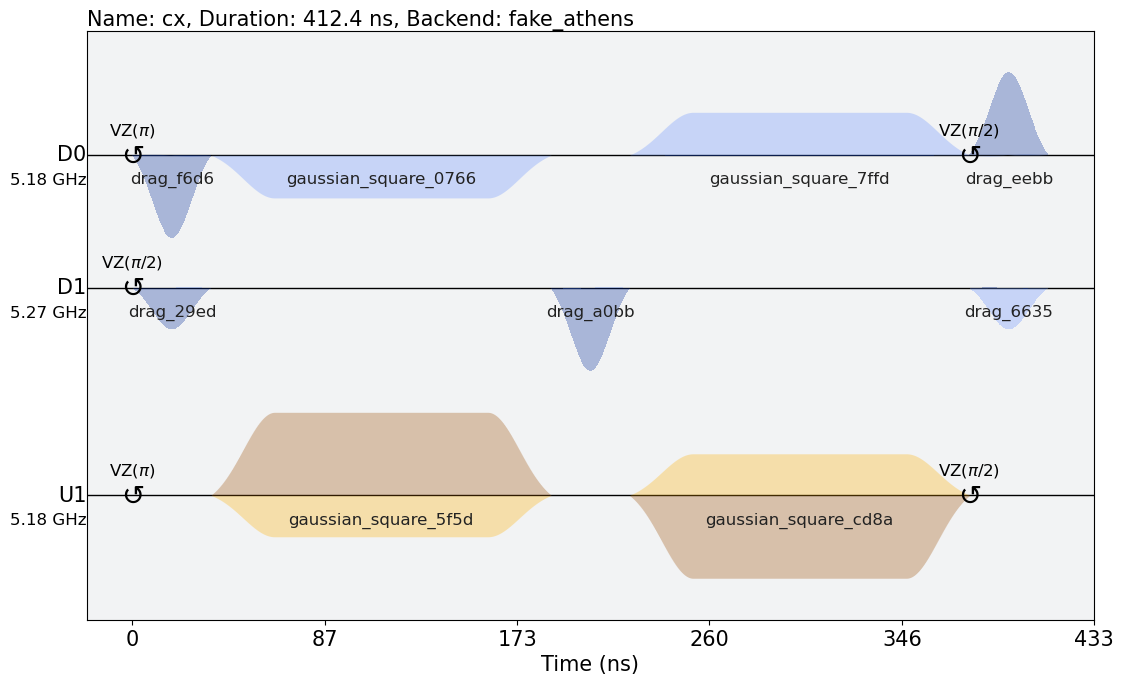

In [32]:
instmap = backend.defaults().instruction_schedule_map
instmap.get("cx", [0,1]).draw(backend=backend)

In [40]:
pulse_par = instmap.get('cx', (0, 1)).filter(channels = [pulse.ControlChannel(1)], instruction_types=[pulse.Play]).instructions[0][1].pulse
pulse_par

GaussianSquare(duration=688, sigma=64, width=432, amp=0.23977785830910736, angle=-1.1070805025145487, name='gaussian_square_5f5d')

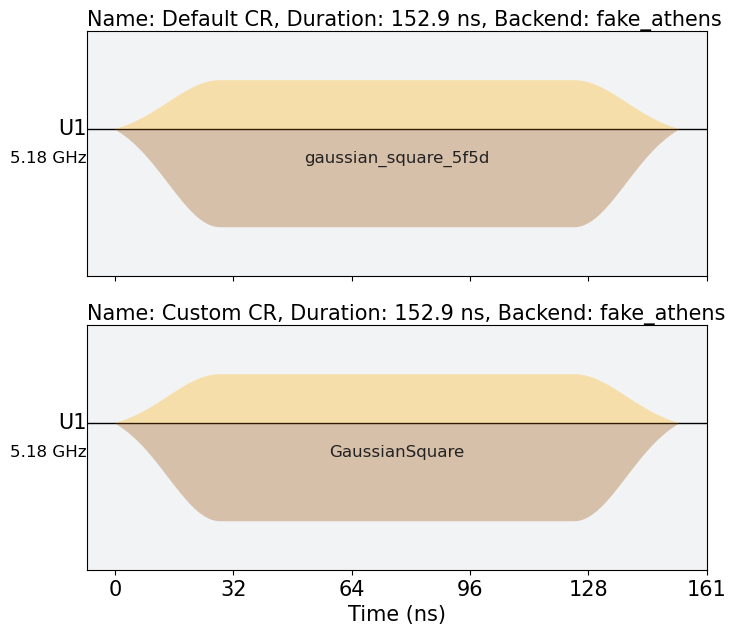

In [41]:
pulse_amp = pulse_par.parameters["amp"]
pulse_ang = pulse_par.parameters["angle"]

cr_params = {}
cr_params['duration'] = 688
cr_params['amp'] = (1++1j*np.tan(pulse_ang))*pulse_amp
cr_params['sigma'] = 64
cr_params['width'] = 432
my_cr_pulse = GaussianSquare(**cr_params)

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8, 7))

with pulse.build(backend, name="Default CR") as cr_sched_default:  
        pulse.play(pulse_par, pulse.ControlChannel(1)) 
cr_sched_default.draw(backend = backend, axis=axes[0])
axes[0].set_xlabel("")

with pulse.build(backend, name="Custom CR") as cr_sched_custom:
    pulse.play(my_cr_pulse, pulse.ControlChannel(1))
cr_sched_custom.draw(backend = backend, axis=axes[1])

In [ ]:
from qiskit.pulse.library import GaussianSquare

def build_rx_schedule(t, amp, component = 2):
    ct_bit = 1
    with pulse.build(backend=backend) as rabi_schedule:
        drive_chan_0 = pulse.drive_channel(ct_bit)
        # pulse.shift_phase(phi, drive_chan_0)
        pulse.play(GaussianSquare(int(t), amp, int(120), risefall_sigma_ratio=1), drive_chan_0)
        # pulse.play([1]*int(t), drive_chan_0)
    rabi_gate = circuit.Gate("single_qubit_driving", num_qubits=1, params=[])
    
    q_circuit = QuantumCircuit(2,1)
    q_circuit.append(rabi_gate, [1])
    if component == 0:
        # measure x component
        q_circuit.ry(np.pi/4, 1)
    elif component == 1:
        # measure y component
        q_circuit.rx(np.pi/4, 1)
    q_circuit.add_calibration(rabi_gate, [1], rabi_schedule)
    q_circuit.measure(1,0)
    trans_circuit = transpile(q_circuit, backend)
    return schedule(trans_circuit, backend)
    # return trans_circuit


In [ ]:
h_schedule = build_rx_schedule(400, 0.1+0j, component=0)
h_schedule.draw(backend=backend)

In [ ]:
# delay = np.linspace(0, 50, 2, dtype=int)
num_qb = [0]
# print(delay)
result_delay = []
for num in num_qb:
    # print(t_delay)
    pulse_schedule = build_rx_schedule(20, num)
    test_qobj = assemble(sched_tot,
                        backend = backend_sim,
                        qubit_lo_freq = qubit_lo_freq,
                        meas_level = 1, 
                        meas_return = 'avg',
                        shots = 1024)

    result = backend_sim.run(test_qobj, system_model=backend_model).result()
    # res = result.get_memory(0)
    result_delay.append(result)

In [ ]:

state = np.array(result_delay[0].results[0].data.statevector)
state.shape
# plt.plot( state[:,1] )
# result_delay[0].results[0].data.to_dict()["statevector"]

In [ ]:
2**7

In [ ]:
plt.plot(delay*dt*1e9, 1-np.array(np.real(result_delay)))
# plt.yscale("log")

In [ ]:
ts = (np.linspace(0,20e-9,20)/dt).astype(int)[5:]
component = np.array([0,1,2])
counts = np.zeros((len(component), len(ts)), dtype=float)
num_shots = 256
for i in range(len(component)):
    for j in range(len(ts)):
        pulse_schedule = build_rx_schedule(ts[j], component=component[i])
        test_qobj = assemble(pulse_schedule,
                            backend = backend_sim,
                            qubit_lo_freq = qubit_lo_freq,
                            meas_level = 1, 
                            meas_return = 'avg',
                            shots = num_shots)

        result = backend_sim.run(test_qobj, system_model=backend_model).result()
        # counts of the 1 in the simulation
        counts[i,j] = np.real(result.get_memory(0)[0])

In [ ]:
plt.plot(ts*dt*1e9, counts[0,:], ".-", label="<z>")
plt.plot(ts*dt*1e9, counts[1,:], ".-", label="<x>")
plt.plot(ts*dt*1e9, counts[2,:], ".-", label="<y>")
# plt.plot(phi, counts, ".-")
plt.grid()
plt.xlabel("t(ns)")
plt.legend()
plt.show()